In [194]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.platform import get_file_size
from torchlake.text_classification.models import TextCnn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# setting


In [195]:
data_path = Path("../../data/childrenBooksAndStories")
artifacts_path = Path("../../artifacts/textcnn")

In [196]:
batch_size = 32
context = NlpContext()

In [197]:
tokenizer = get_tokenizer("basic_english")

# data

In [198]:
data = pd.read_csv(
    data_path.joinpath("children_stories.csv").as_posix(),
    encoding="latin-1",
    usecols=["cats", "desc"],
)

In [199]:
# 移除空標籤
data = data.query('cats != "Age "')

In [200]:
def convert_to_bound(label: str) -> tuple[int, int]:
    """convert age label to label

    Args:
        label (str): age label, in format like 'x-y', 'x+'

    Returns:
        tuple[int, int]: lower and upper bound
    """

    label = label.replace("6months", "0.5")

    if "-" in label:
        [lower, upper] = label.split("-")
        lower, upper = float(lower), float(upper)
    else:
        lower = float(label.replace("+", ""))
        upper = np.Inf

    return (lower, upper)

In [201]:
def convert_to_label(lower: float, upper: float) -> int:
    """convert age bound to label

    Args:
        lower (float): lower bound of age
        upper (float): upper bound of age

    Returns:
        int: 0 -> before kindergarten, 1 -> kindergarten, 2 -> elementary school
    """
    if lower >= 8:
        return 2
    elif lower >= 3:
        return 1
    else:
        return 0

In [202]:
data["cats"] = data.cats.str.replace("Age\s", "", regex=True)

In [203]:
data["cats"] = data.cats.apply(convert_to_bound)

In [204]:
data.cats.value_counts().sort_index()

cats
(0.0, 2.0)       2
(0.0, 3.0)      12
(0.0, 4.0)      16
(0.0, 5.0)       8
(0.0, 6.0)       1
(0.0, inf)      13
(0.5, inf)       1
(1.0, 2.0)       1
(1.0, 3.0)       6
(1.0, 4.0)       4
(1.0, 5.0)       5
(1.0, 6.0)       1
(1.0, inf)       2
(2.0, 4.0)       1
(2.0, 5.0)       9
(2.0, 6.0)      10
(2.0, 7.0)       1
(2.0, 9.0)      20
(2.0, inf)      12
(3.0, 4.0)       1
(3.0, 5.0)       7
(3.0, 6.0)       9
(3.0, 7.0)       5
(3.0, inf)      32
(4.0, 5.0)       1
(4.0, 6.0)       3
(4.0, 7.0)       2
(4.0, 8.0)       3
(4.0, 11.0)      1
(4.0, inf)      20
(5.0, 8.0)       3
(5.0, 9.0)       2
(5.0, inf)      17
(6.0, 8.0)       2
(6.0, 9.0)       1
(6.0, 11.0)      3
(6.0, inf)      21
(7.0, 9.0)       2
(7.0, 10.0)      2
(7.0, 11.0)      4
(7.0, 12.0)      1
(7.0, inf)      27
(8.0, 11.0)      1
(8.0, 12.0)      4
(8.0, inf)      26
(9.0, 11.0)      3
(9.0, 12.0)      2
(9.0, 13.0)      2
(9.0, 14.0)      1
(9.0, inf)      32
(10.0, 14.0)     1
(10.0, inf)     26
(11.0, 

In [205]:
CLASS_NAMES = ["3y-", "3~8y", "8y+"]

In [206]:
data["cats"] = data.cats.apply(lambda bound: convert_to_label(*bound))

In [233]:
data.cats.value_counts().sort_index()

cats
0    125
1    169
2    134
Name: count, dtype: int64

In [207]:
train_data, test_data = train_test_split(data, test_size=1 / 5)

In [208]:
vocab = build_vocab_from_iterator(
    train_data["desc"].str.split(),
    specials=context.special_tokens,
    min_freq=context.min_frequency,
)

vocab.set_default_index(context.unk_idx)

In [209]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [210]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for label, text in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [211]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [212]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([32, 256]) torch.Size([32])


# model


In [213]:
VOCAB_SIZE = len(vocab)
LABEL_SIZE = data.cats.nunique()

In [214]:
DEVICE = torch.device(context.device)

In [215]:
EMBED_DIM = 32

In [216]:
model = TextCnn(VOCAB_SIZE, EMBED_DIM, output_size=LABEL_SIZE, padding_idx=context.padding_idx).to(DEVICE)

In [217]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
TextCnn                                       --
├─Embedding: 1-1                              29,568
├─MultiKernelConvModule: 1-2                  --
│    └─FlattenFeature: 2-1                    --
│    │    └─Sequential: 3-1                   --
│    └─ModuleList: 2-2                        --
│    │    └─ConvBnRelu: 3-2                   9,700
│    │    └─ConvBnRelu: 3-3                   12,900
│    │    └─ConvBnRelu: 3-4                   16,100
├─Linear: 1-3                                 903
Total params: 69,171
Trainable params: 69,171
Non-trainable params: 0

# train


In [218]:
EPOCHES = 20

In [219]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [220]:
criterion = trainer.get_criterion(LABEL_SIZE)
optimizer = torch.optim.Adam(model.parameters())

In [221]:
training_loss = trainer.run(train_iter, model, optimizer, criterion)

100%|██████████| 10/10 [00:00<00:00, 26.32it/s]


epoch 1 : 0.5476763904094696


100%|██████████| 10/10 [00:00<00:00, 34.46it/s]


epoch 2 : 0.4571013182401657


100%|██████████| 10/10 [00:00<00:00, 63.06it/s]


epoch 3 : 0.4095168739557266


100%|██████████| 10/10 [00:00<00:00, 84.97it/s]


epoch 4 : 0.36796596050262453


100%|██████████| 10/10 [00:00<00:00, 91.15it/s]


epoch 5 : 0.3231422692537308


100%|██████████| 10/10 [00:00<00:00, 73.73it/s]


epoch 6 : 0.274935083091259


100%|██████████| 10/10 [00:00<00:00, 90.78it/s]


epoch 7 : 0.2615450620651245


100%|██████████| 10/10 [00:00<00:00, 90.57it/s]


epoch 8 : 0.21865840405225753


100%|██████████| 10/10 [00:00<00:00, 79.59it/s]


epoch 9 : 0.19761861115694046


100%|██████████| 10/10 [00:00<00:00, 87.49it/s]


epoch 10 : 0.16456803381443025


100%|██████████| 10/10 [00:00<00:00, 87.23it/s]


epoch 11 : 0.14419522881507874


100%|██████████| 10/10 [00:00<00:00, 88.73it/s]


epoch 12 : 0.1200312539935112


100%|██████████| 10/10 [00:00<00:00, 87.19it/s]


epoch 13 : 0.10818595662713051


100%|██████████| 10/10 [00:00<00:00, 56.97it/s]


epoch 14 : 0.09459726437926293


100%|██████████| 10/10 [00:00<00:00, 72.66it/s]


epoch 15 : 0.08217835053801537


100%|██████████| 10/10 [00:00<00:00, 80.86it/s]


epoch 16 : 0.06965986602008342


100%|██████████| 10/10 [00:00<00:00, 84.26it/s]


epoch 17 : 0.058989540114998816


100%|██████████| 10/10 [00:00<00:00, 80.86it/s]


epoch 18 : 0.05141771398484707


100%|██████████| 10/10 [00:00<00:00, 82.87it/s]


epoch 19 : 0.046194658428430554


100%|██████████| 10/10 [00:00<00:00, 73.19it/s]

epoch 20 : 0.041906974837183954


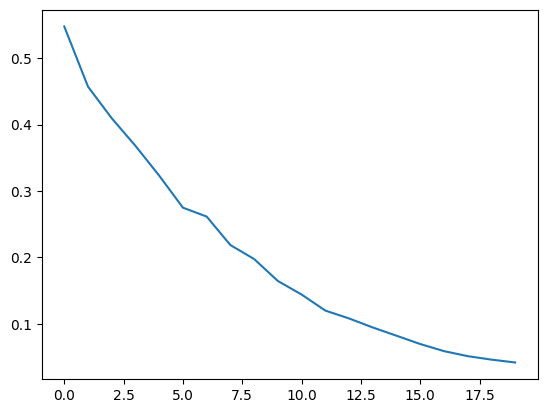

In [222]:
plt.plot(training_loss)

# inference


In [223]:
evaluator = ClassificationEvaluator(LABEL_SIZE, DEVICE)

In [224]:
confusion_matrix = evaluator.run(test_iter, model)

100%|██████████| 3/3 [00:00<00:00, 120.32it/s]

[[18  8  3]
 [ 0 19  8]
 [ 0  7 23]]


In [225]:
per_class_accuracy = evaluator.get_per_class_accuracy(confusion_matrix)

In [226]:
evaluator.show_per_class_accuracy(CLASS_NAMES, per_class_accuracy)

3y-       : 0.6206896551724138
3~8y      : 0.7037037037037037
8y+       : 0.7666666666666667


In [227]:
evaluator.get_total_accuracy(confusion_matrix)

array(0.69767442)

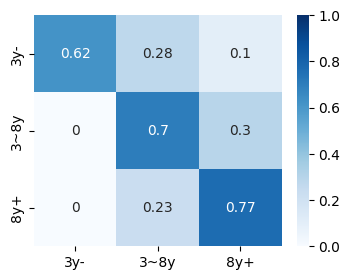

In [228]:
evaluator.plot_confusion_matrix(confusion_matrix, CLASS_NAMES, cmap="Blues")

# File

In [229]:
model_path = artifacts_path.joinpath("textcnn.pth")

In [230]:
torch.save(model.state_dict(), model_path)

In [231]:
get_file_size(model_path, unit="K")

'273.75KB'

In [232]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>